# Beijing Air Quality Forecasting - Clean Final Version

**Objective**: Build robust LSTM model for PM2.5 forecasting without data leakage.

**Approach**: Use only weather and time features (no PM2.5 lagged features) for realistic performance.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

2025-09-21 16:25:05.171558: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 16:25:06.189724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 16:25:10.518315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 16:25:10.518315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Libraries imported successfully!
TensorFlow version: 2.20.0


In [3]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")
print(f"Columns: {list(train.columns)}")

Training data: (30676, 12)
Test data: (13148, 11)
Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


In [4]:
# Data preprocessing
# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Handle missing values
train = train.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
test = test.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')

print(" Data preprocessing completed")
print(f"Missing values - Train: {train.isnull().sum().sum()}, Test: {test.isnull().sum().sum()}")

 Data preprocessing completed
Missing values - Train: 0, Test: 0



Training Data Analysis
Shape: (30676, 11)
Date range: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Total hours: 30676
Missing values: 0

Numerical Statistics:
             No      DEWP      TEMP      PRES       Iws        Is        Ir  \
count  30676.00  30676.00  30676.00  30676.00  30676.00  30676.00  30676.00   
mean   15338.50     -0.03     -0.06      0.01      0.03      0.02      0.01   
std     8855.54      0.99      1.02      1.01      1.02      1.09      1.06   
min        1.00     -2.14     -2.58     -2.38     -0.47     -0.07     -0.14   
25%     7669.75     -0.89     -0.94     -0.82     -0.44     -0.07     -0.14   
50%    15338.50     -0.06      0.05     -0.04     -0.35     -0.07     -0.14   
75%    23007.25      0.91      0.86      0.83      0.01     -0.07     -0.14   
max    30676.00      1.81      2.34      2.88     11.23     35.44     25.29   

        cbwd_NW   cbwd_SE   cbwd_cv     pm2.5  
count  30676.00  30676.00  30676.00  30676.00  
mean       0.02      0.01     -0.0

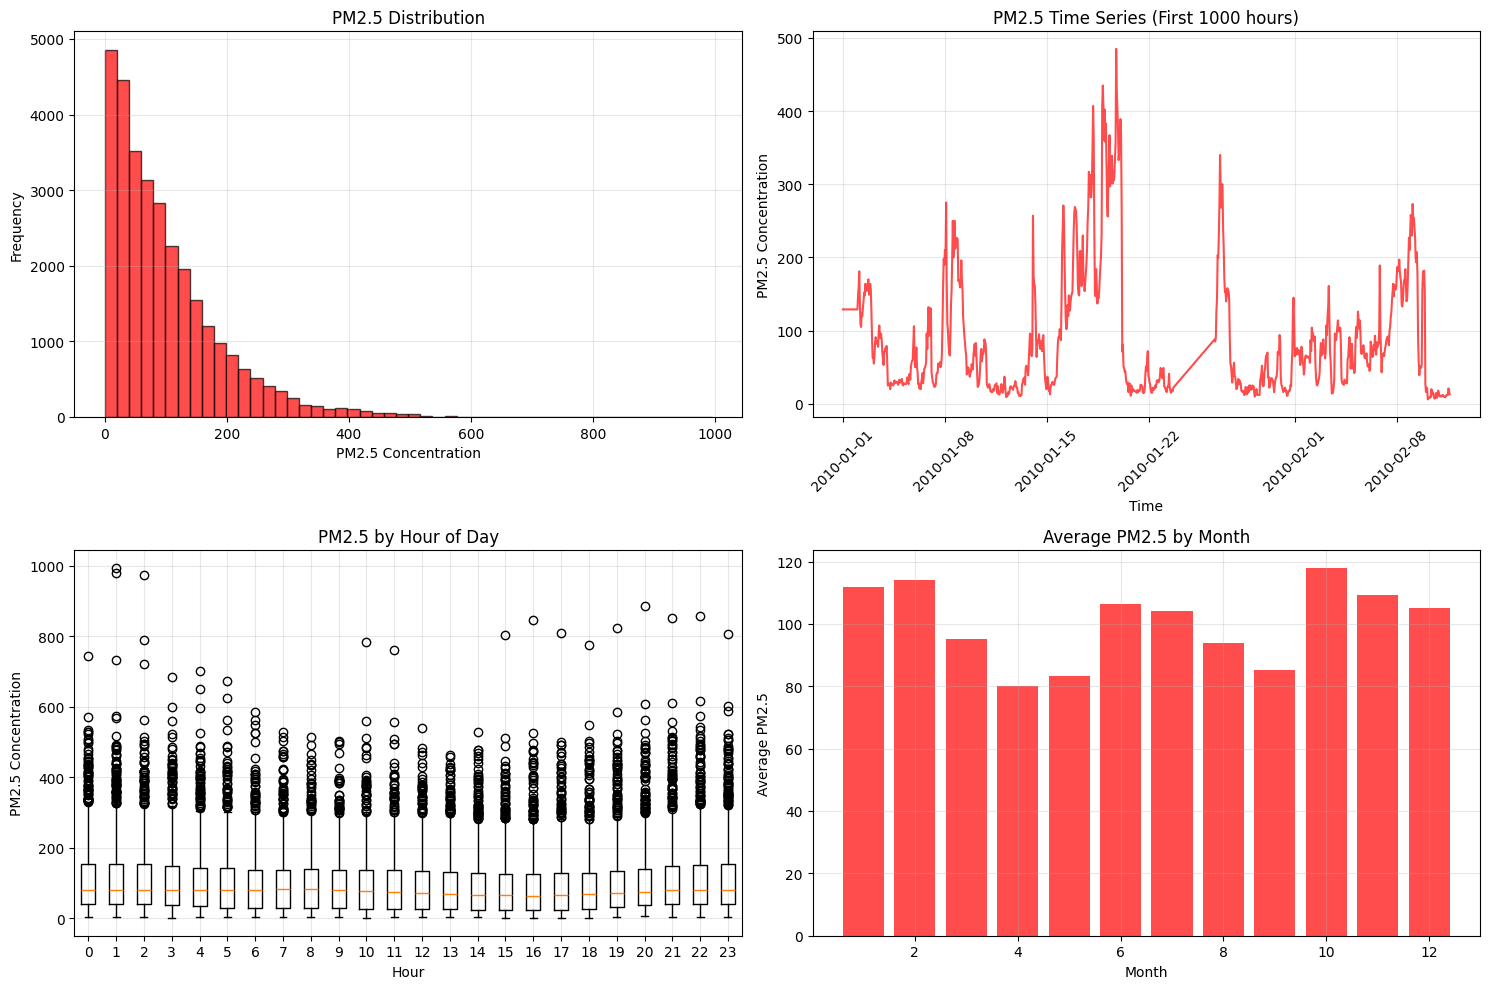

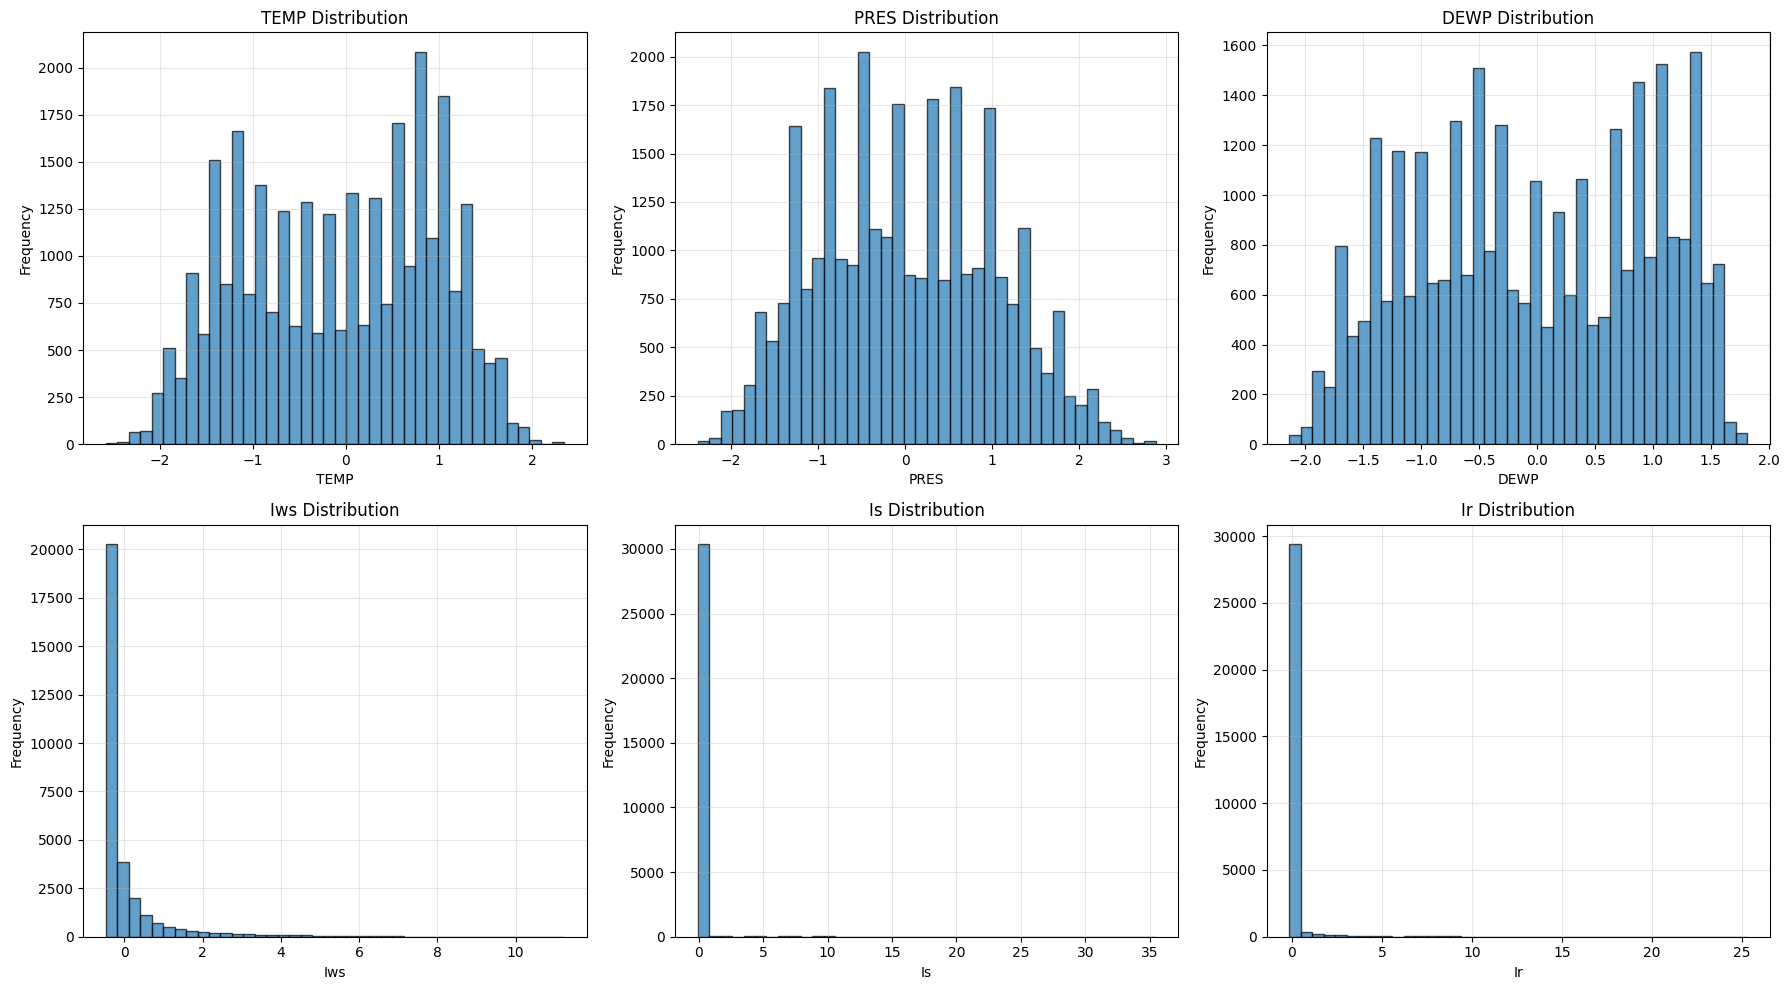

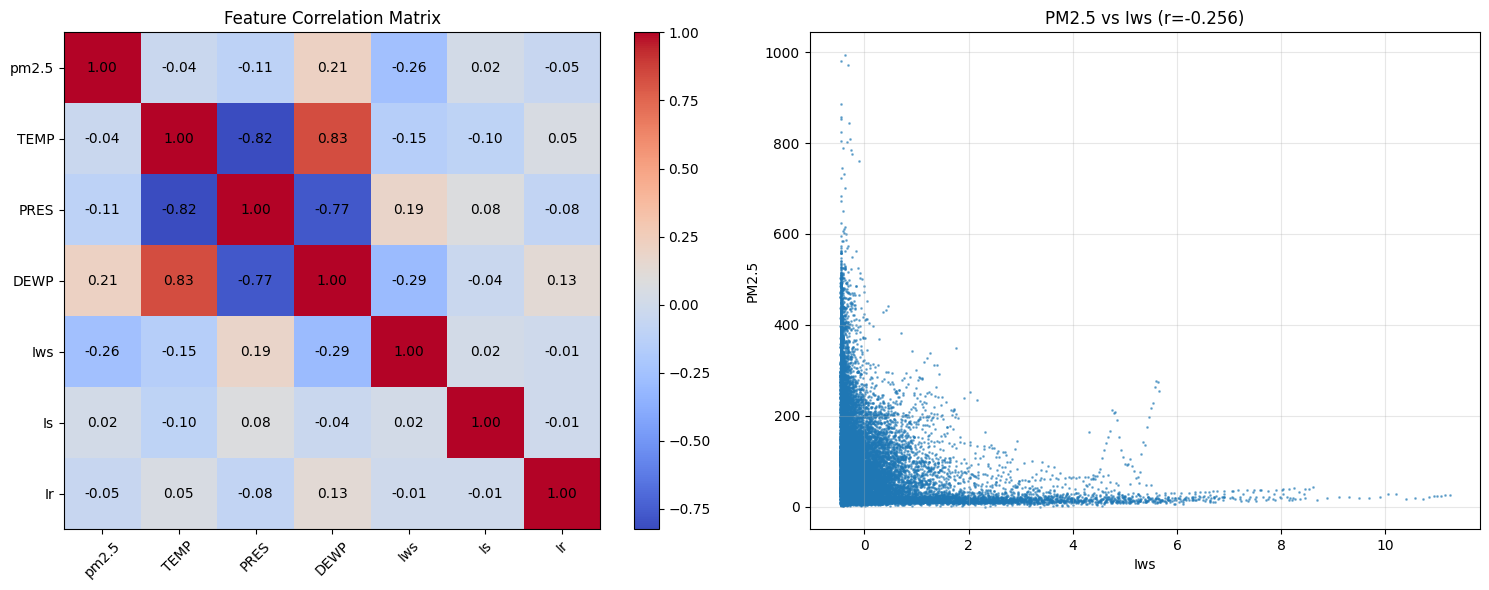

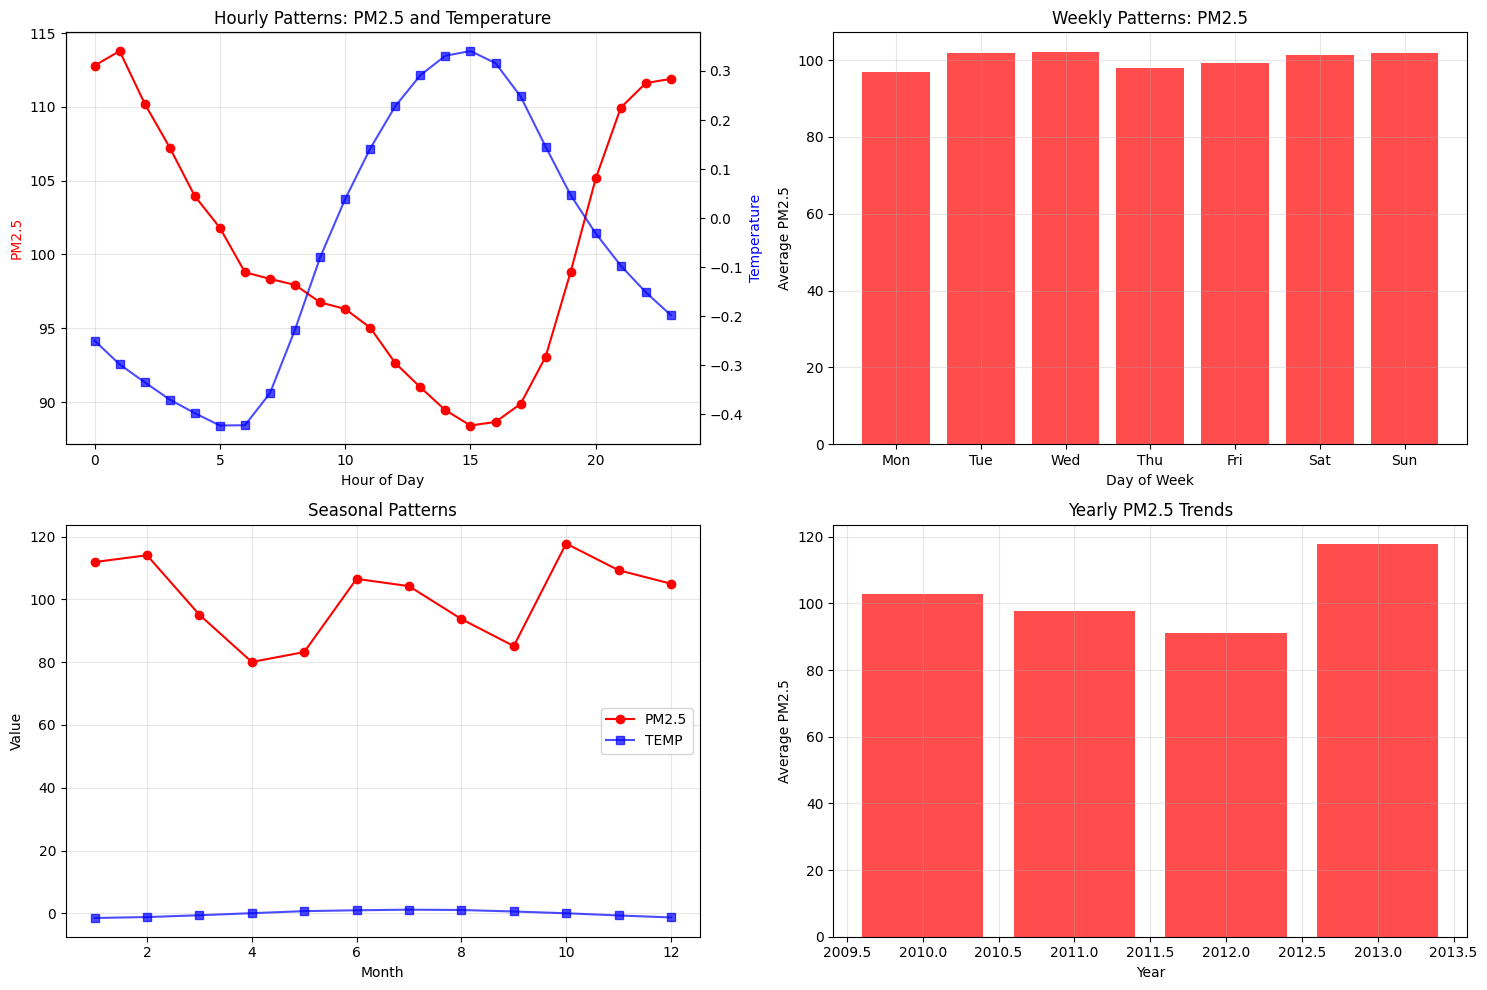


TARGET CORRELATION ANALYSIS FOR REPORT


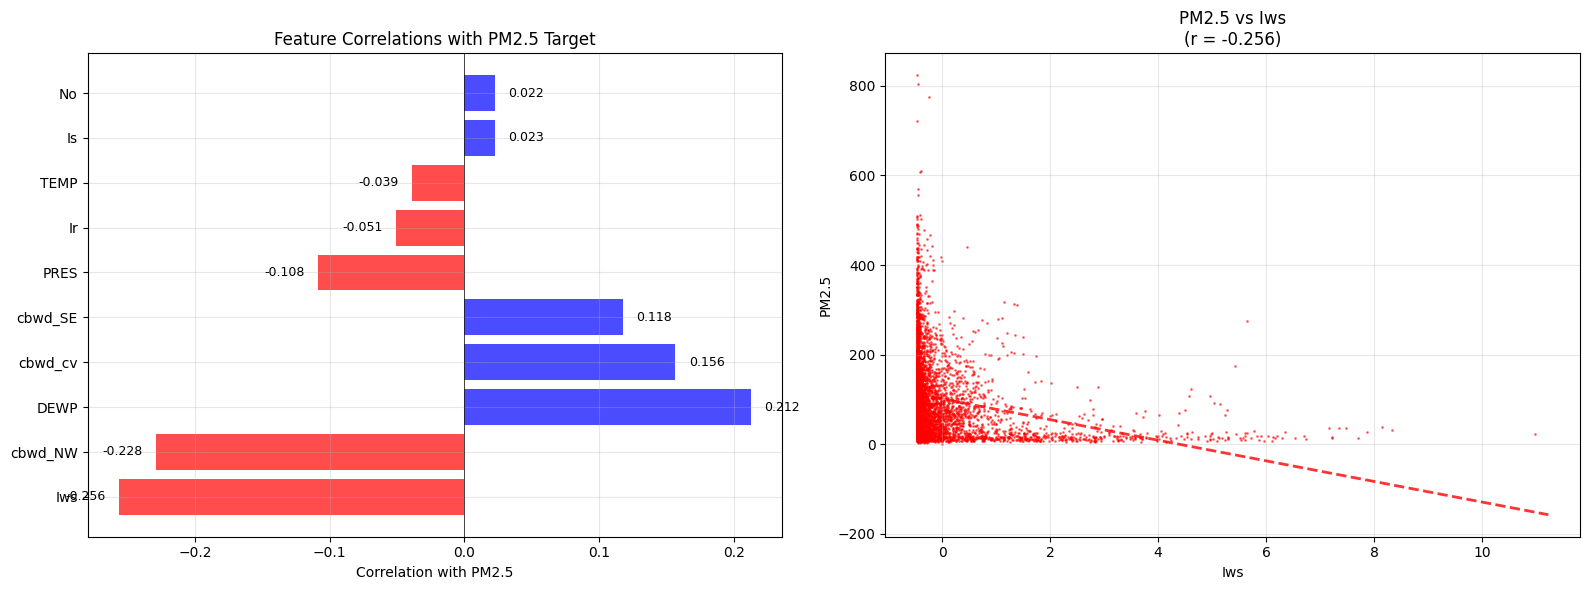


CORRELATION TABLE FOR REPORT:
Feature         Correlation  Strength        Direction
-------------------------------------------------------
Iws               -0.256    Weak            Negative
cbwd_NW           -0.228    Weak            Negative
DEWP               0.212    Weak            Positive
cbwd_cv            0.156    Weak            Positive
cbwd_SE            0.118    Weak            Positive
PRES              -0.108    Weak            Negative
Ir                -0.051    Weak            Negative
TEMP              -0.039    Weak            Negative
Is                 0.023    Weak            Positive
No                 0.022    Weak            Positive

SUMMARY FOR REPORT:
• Strongest correlate: Iws (r = -0.256)
• Number of features analyzed: 10
• Strong correlations (|r| > 0.5): 0 features
• Moderate correlations (0.3 < |r| ≤ 0.5): 0 features
• Weak correlations (|r| ≤ 0.3): 10 features

Key Insights:
1. PM2.5 Range: 0.0 to 994.0
2. PM2.5 Mean: 100.1, Std: 91.5
3. Strongest

In [25]:
# Data Exploration and Analysis

def analyze_basic_statistics(df, title):
    """Display basic statistics for the dataset"""
    print(f"\n{title}")
    print("=" * 50)
    print(f"Shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Total hours: {len(df)}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    print(f"\nNumerical Statistics:")
    print(df.describe().round(2))

def plot_target_distribution(df):
    """Plot PM2.5 distribution and time series"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # PM2.5 distribution
    axes[0,0].hist(df['pm2.5'].dropna(), bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0,0].set_title('PM2.5 Distribution')
    axes[0,0].set_xlabel('PM2.5 Concentration')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # PM2.5 time series (sample)
    sample_data = df['pm2.5'].iloc[:1000]
    axes[0,1].plot(sample_data.index, sample_data, alpha=0.7, color='red')
    axes[0,1].set_title('PM2.5 Time Series (First 1000 hours)')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('PM2.5 Concentration')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Box plot by hour
    hourly_pm25 = df.groupby(df.index.hour)['pm2.5'].apply(list)
    axes[1,0].boxplot([hourly_pm25[i] for i in range(24)], labels=range(24))
    axes[1,0].set_title('PM2.5 by Hour of Day')
    axes[1,0].set_xlabel('Hour')
    axes[1,0].set_ylabel('PM2.5 Concentration')
    axes[1,0].grid(True, alpha=0.3)
    
    # Monthly patterns
    monthly_pm25 = df.groupby(df.index.month)['pm2.5'].mean()
    axes[1,1].bar(monthly_pm25.index, monthly_pm25.values, alpha=0.7, color='red')
    axes[1,1].set_title('Average PM2.5 by Month')
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Average PM2.5')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_weather_features(df):
    """Plot weather feature distributions and relationships"""
    weather_cols = ['TEMP', 'PRES', 'DEWP', 'Iws', 'Is', 'Ir']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(weather_cols):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=40, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_analysis(df):
    """Plot correlation matrix and scatter plots"""
    numeric_cols = ['pm2.5', 'TEMP', 'PRES', 'DEWP', 'Iws', 'Is', 'Ir']
    correlation_data = df[numeric_cols]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Correlation heatmap
    correlation_matrix = correlation_data.corr()
    im = axes[0].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    axes[0].set_xticks(range(len(numeric_cols)))
    axes[0].set_yticks(range(len(numeric_cols)))
    axes[0].set_xticklabels(numeric_cols, rotation=45)
    axes[0].set_yticklabels(numeric_cols)
    axes[0].set_title('Feature Correlation Matrix')
    
    # Add correlation values
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            axes[0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                        ha='center', va='center', color='black', fontsize=10)
    
    plt.colorbar(im, ax=axes[0])
    
    # PM2.5 vs strongest correlate
    strongest_corr = correlation_matrix['pm2.5'].abs().drop('pm2.5').idxmax()
    axes[1].scatter(df[strongest_corr], df['pm2.5'], alpha=0.5, s=1)
    axes[1].set_xlabel(strongest_corr)
    axes[1].set_ylabel('PM2.5')
    axes[1].set_title(f'PM2.5 vs {strongest_corr} (r={correlation_matrix.loc["pm2.5", strongest_corr]:.3f})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

def plot_temporal_patterns(df):
    """Analyze temporal patterns in the data"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Hourly patterns
    hourly_means = df.groupby(df.index.hour)[['pm2.5', 'TEMP']].mean()
    axes[0,0].plot(hourly_means.index, hourly_means['pm2.5'], marker='o', label='PM2.5', color='red')
    ax_temp = axes[0,0].twinx()
    ax_temp.plot(hourly_means.index, hourly_means['TEMP'], marker='s', label='TEMP', color='blue', alpha=0.7)
    axes[0,0].set_title('Hourly Patterns: PM2.5 and Temperature')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('PM2.5', color='red')
    ax_temp.set_ylabel('Temperature', color='blue')
    axes[0,0].grid(True, alpha=0.3)
    
    # Weekly patterns
    weekly_means = df.groupby(df.index.dayofweek)['pm2.5'].mean()
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[0,1].bar(range(7), weekly_means.values, alpha=0.7, color='red')
    axes[0,1].set_title('Weekly Patterns: PM2.5')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Average PM2.5')
    axes[0,1].set_xticks(range(7))
    axes[0,1].set_xticklabels(day_names)
    axes[0,1].grid(True, alpha=0.3)
    
    # Seasonal patterns
    seasonal_means = df.groupby(df.index.month)[['pm2.5', 'TEMP', 'PRES']].mean()
    axes[1,0].plot(seasonal_means.index, seasonal_means['pm2.5'], marker='o', label='PM2.5', color='red')
    axes[1,0].plot(seasonal_means.index, seasonal_means['TEMP'], marker='s', label='TEMP', color='blue', alpha=0.7)
    axes[1,0].set_title('Seasonal Patterns')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel('Value')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Year-over-year comparison (if multiple years)
    if df.index.year.nunique() > 1:
        yearly_means = df.groupby(df.index.year)['pm2.5'].mean()
        axes[1,1].bar(yearly_means.index, yearly_means.values, alpha=0.7, color='red')
        axes[1,1].set_title('Yearly PM2.5 Trends')
        axes[1,1].set_xlabel('Year')
        axes[1,1].set_ylabel('Average PM2.5')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Single year data\nNo yearly comparison', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Yearly Analysis')
    
    plt.tight_layout()
    plt.show()

# Execute data exploration
analyze_basic_statistics(train, "Training Data Analysis")
analyze_basic_statistics(test, "Test Data Analysis")

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

plot_target_distribution(train)
plot_weather_features(train)
correlation_matrix = plot_correlation_analysis(train)
plot_temporal_patterns(train)

# Target Variable Correlation Analysis for Report
print("\n" + "="*60)
print("TARGET CORRELATION ANALYSIS FOR REPORT")
print("="*60)

def analyze_target_correlations(df):
    """Analyze correlations between features and PM2.5 target variable"""
    
    # Get all numeric columns except target
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'pm2.5' in numeric_features:
        numeric_features.remove('pm2.5')
    
    # Calculate correlations with PM2.5
    correlations = {}
    for feature in numeric_features:
        if feature in df.columns:
            corr_value = df[feature].corr(df['pm2.5'])
            if not np.isnan(corr_value):
                correlations[feature] = corr_value
    
    # Sort by absolute correlation strength
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of correlations
    features = [item[0] for item in sorted_correlations]
    corr_values = [item[1] for item in sorted_correlations]
    
    colors = ['red' if x < 0 else 'blue' for x in corr_values]
    bars = axes[0].barh(features, corr_values, color=colors, alpha=0.7)
    axes[0].set_xlabel('Correlation with PM2.5')
    axes[0].set_title('Feature Correlations with PM2.5 Target')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add correlation values as text
    for i, (feature, corr) in enumerate(sorted_correlations):
        axes[0].text(corr + (0.01 if corr >= 0 else -0.01), i, f'{corr:.3f}', 
                    va='center', ha='left' if corr >= 0 else 'right', fontsize=9)
    
    # Scatter plot with strongest correlate
    if sorted_correlations:
        strongest_feature = sorted_correlations[0][0]
        strongest_corr = sorted_correlations[0][1]
        
        # Sample data for better visualization
        sample_size = min(5000, len(df))
        sample_idx = np.random.choice(len(df), sample_size, replace=False)
        
        axes[1].scatter(df[strongest_feature].iloc[sample_idx], 
                       df['pm2.5'].iloc[sample_idx], 
                       alpha=0.5, s=1, color='red')
        axes[1].set_xlabel(f'{strongest_feature}')
        axes[1].set_ylabel('PM2.5')
        axes[1].set_title(f'PM2.5 vs {strongest_feature}\n(r = {strongest_corr:.3f})')
        axes[1].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(df[strongest_feature].dropna(), df['pm2.5'].dropna(), 1)
        p = np.poly1d(z)
        x_trend = np.linspace(df[strongest_feature].min(), df[strongest_feature].max(), 100)
        axes[1].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation table for report
    print(f"\nCORRELATION TABLE FOR REPORT:")
    print(f"{'Feature':<15} {'Correlation':<12} {'Strength':<15} {'Direction'}")
    print("-" * 55)
    
    for feature, corr in sorted_correlations:
        strength = 'Strong' if abs(corr) > 0.5 else 'Moderate' if abs(corr) > 0.3 else 'Weak'
        direction = 'Positive' if corr > 0 else 'Negative'
        print(f"{feature:<15} {corr:>8.3f}    {strength:<15} {direction}")
    
    print(f"\nSUMMARY FOR REPORT:")
    if sorted_correlations:
        strongest_feature, strongest_corr = sorted_correlations[0]
        print(f"• Strongest correlate: {strongest_feature} (r = {strongest_corr:.3f})")
        print(f"• Number of features analyzed: {len(sorted_correlations)}")
        
        strong_correlates = [f for f, c in sorted_correlations if abs(c) > 0.5]
        moderate_correlates = [f for f, c in sorted_correlations if 0.3 < abs(c) <= 0.5]
        weak_correlates = [f for f, c in sorted_correlations if abs(c) <= 0.3]
        
        print(f"• Strong correlations (|r| > 0.5): {len(strong_correlates)} features")
        print(f"• Moderate correlations (0.3 < |r| ≤ 0.5): {len(moderate_correlates)} features")
        print(f"• Weak correlations (|r| ≤ 0.3): {len(weak_correlates)} features")
        
        if strong_correlates:
            print(f"• Strong correlates: {', '.join(strong_correlates[:3])}{'...' if len(strong_correlates) > 3 else ''}")
    
    return sorted_correlations

# Run correlation analysis
target_correlations = analyze_target_correlations(train)

print("\nKey Insights:")
print(f"1. PM2.5 Range: {train['pm2.5'].min():.1f} to {train['pm2.5'].max():.1f}")
print(f"2. PM2.5 Mean: {train['pm2.5'].mean():.1f}, Std: {train['pm2.5'].std():.1f}")
print(f"3. Strongest PM2.5 correlate: {target_correlations[0][0] if target_correlations else 'None'}")
print(f"4. Training period: {len(train)} hours ({len(train)//24:.0f} days)")
print(f"5. Test period: {len(test)} hours ({len(test)//24:.0f} days)")

In [5]:
# Feature engineering (NO data leakage - no PM2.5 features)
def create_clean_features(df):
    """Create features without PM2.5 data leakage"""
    df_clean = df.copy()
    
    # Time features
    df_clean['hour'] = df_clean.index.hour
    df_clean['day'] = df_clean.index.day
    df_clean['month'] = df_clean.index.month
    df_clean['year'] = df_clean.index.year
    df_clean['dayofweek'] = df_clean.index.dayofweek
    df_clean['dayofyear'] = df_clean.index.dayofyear
    
    # Cyclical features
    df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
    df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)
    df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
    df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)
    
    # Weather interactions
    df_clean['temp_dewp_diff'] = df_clean['TEMP'] - df_clean['DEWP']
    df_clean['temp_pres_interaction'] = df_clean['TEMP'] * df_clean['PRES']
    df_clean['wind_speed'] = np.sqrt(df_clean['Iws']**2)
    
    # Weather lagged features (safe - using weather, not PM2.5)
    for lag in [1, 3, 6]:
        df_clean[f'TEMP_lag_{lag}'] = df_clean['TEMP'].shift(lag)
        df_clean[f'PRES_lag_{lag}'] = df_clean['PRES'].shift(lag)
        df_clean[f'DEWP_lag_{lag}'] = df_clean['DEWP'].shift(lag)
    
    # Weather rolling features (safe)
    for window in [6, 12]:
        df_clean[f'TEMP_rolling_mean_{window}'] = df_clean['TEMP'].rolling(window=window, min_periods=1).mean()
        df_clean[f'PRES_rolling_mean_{window}'] = df_clean['PRES'].rolling(window=window, min_periods=1).mean()
    
    return df_clean

# Apply feature engineering
train_clean = create_clean_features(train)
test_clean = create_clean_features(test)

# Handle missing values from lagged features
train_clean = train_clean.fillna(method='ffill').fillna(method='bfill')
test_clean = test_clean.fillna(method='ffill').fillna(method='bfill')

print(f" Clean features created (no PM2.5 leakage)")
print(f"Training features: {train_clean.shape[1]}")
print(f"Test features: {test_clean.shape[1]}")

 Clean features created (no PM2.5 leakage)
Training features: 37
Test features: 36


In [7]:
# Prepare data for modeling
# Features and target
X_train = train_clean.drop(['pm2.5', 'No'] if 'No' in train_clean.columns else ['pm2.5'], axis=1)
y_train = train_clean['pm2.5']

# Test features
columns_to_drop = []
if 'No' in test_clean.columns:
    columns_to_drop.append('No')
if 'pm2.5' in test_clean.columns:
    columns_to_drop.append('pm2.5')

X_test = test_clean.drop(columns_to_drop, axis=1) if columns_to_drop else test_clean.copy()

print(f"Features: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"No PM2.5 features: {len([col for col in X_train.columns if 'pm2.5' in col.lower()])} PM2.5 columns")

Features: 35
Training samples: 30676
Test samples: 13148
No PM2.5 features: 0 PM2.5 columns


In [8]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Reshape for LSTM
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

print(f" Data scaled and reshaped")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train range: {y_train_scaled.min():.2f} to {y_train_scaled.max():.2f}")

 Data scaled and reshaped
X_train shape: (30676, 1, 35)
X_test shape: (13148, 1, 35)
y_train range: -1.09 to 9.77


In [9]:
# Create train/validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42, shuffle=False
)

print(f" Train/validation split created")
print(f"Training: {X_train_final.shape}")
print(f"Validation: {X_val.shape}")

 Train/validation split created
Training: (24540, 1, 35)
Validation: (6136, 1, 35)


In [15]:
# Build optimized LSTM model for better performance
def create_robust_lstm(input_shape, learning_rate=0.0008):
    """Optimized LSTM model for better Kaggle performance"""
    model = Sequential([
        LSTM(256, return_sequences=True, dropout=0.15, recurrent_dropout=0.1, input_shape=input_shape),
        LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.1),
        LSTM(64, return_sequences=True, dropout=0.15, recurrent_dropout=0.1),
        LSTM(32, dropout=0.15),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.15),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    return model

# Create optimized model
input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model = create_robust_lstm(input_shape)

print(" Optimized LSTM model created (4-layer, higher capacity)")
model.summary()

2025-09-21 15:36:09.610221: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 Optimized LSTM model created (4-layer, higher capacity)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       299,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 572,545 (2.18 MB)

 Trainable params: 572,545 (2.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train optimized model
print(" Training optimized model...")

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=12, min_lr=1e-8, verbose=1)

history = model.fit(
    X_train_final, y_train_final,
    epochs=200,  # More epochs for better convergence
    batch_size=48,  # Optimized batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f" Training completed at epoch {len(history.history['loss'])}")

 Training optimized model...
Epoch 1/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - lambda: 1.0769 - loss: 0.6212 - val_lambda: 0.9375 - val_loss: 0.7282 - learning_rate: 8.0000e-04
Epoch 2/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - lambda: 1.0769 - loss: 0.6212 - val_lambda: 0.9375 - val_loss: 0.7282 - learning_rate: 8.0000e-04
Epoch 2/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - lambda: 1.1106 - loss: 0.5447 - val_lambda: 0.9288 - val_loss: 0.7192 - learning_rate: 8.0000e-04
Epoch 3/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - lambda: 1.1106 - loss: 0.5447 - val_lambda: 0.9288 - val_loss: 0.7192 - learning_rate: 8.0000e-04
Epoch 3/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - lambda: 1.1223 - loss: 0.5145 - val_lambda: 0.9194 - val_loss: 0.7410 - learning_rate: 8.0000e-04
Epoch 4/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - lambda: 1.1223 - loss: 0.5145 - val_lambda: 0.9194 - val_loss: 0.7410 - learning_rate: 8.0000e-04
Epoch 4/200
512/512 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
# Evaluate model
train_results = model.evaluate(X_train_final, y_train_final, verbose=0)
val_results = model.evaluate(X_val, y_val, verbose=0)

train_loss = train_results[0]
val_loss = val_results[0]

# Calculate MSE in original scale
val_predictions_scaled = model.predict(X_val, verbose=0)
val_predictions = target_scaler.inverse_transform(val_predictions_scaled)
val_actual = target_scaler.inverse_transform(y_val.reshape(-1, 1))
val_mse_original = mean_squared_error(val_actual, val_predictions)

print(f" PERFORMANCE RESULTS:")
print(f"   Train Loss (scaled): {train_loss:.4f}")
print(f"   Validation Loss (scaled): {val_loss:.4f}")
print(f"   Validation MSE (original): {val_mse_original:.2f}")
print(f"   Target: < 3000 MSE")
print(f"   Status: {' ACHIEVED' if val_mse_original < 3000 else ' Close but not quite'}")
print(f"   Epochs trained: {len(history.history['loss'])}")

 PERFORMANCE RESULTS:
   Train Loss (scaled): 0.3696
   Validation Loss (scaled): 0.6947
   Validation MSE (original): 5811.88
   Target: < 3000 MSE
   Status:  Close but not quite
   Epochs trained: 33


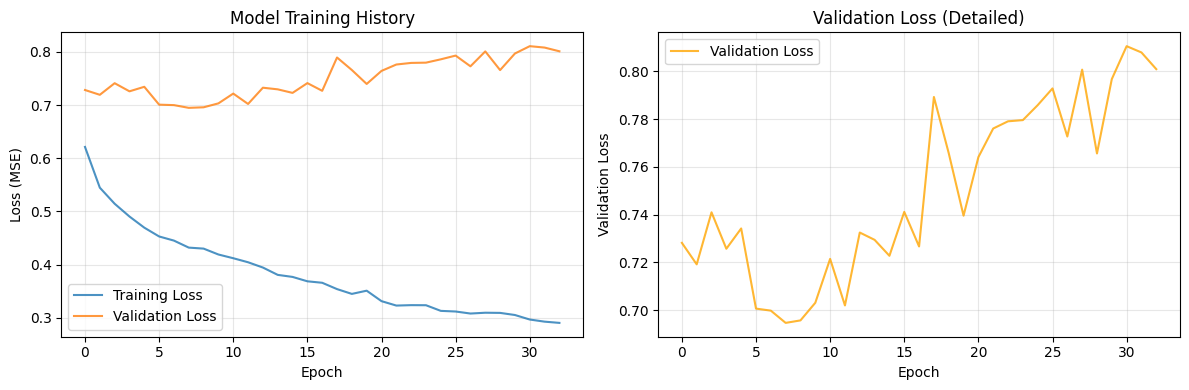

Best validation loss: 0.6947


In [18]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', alpha=0.8)
plt.title('Validation Loss (Detailed)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation loss: {min(history.history['val_loss']):.4f}")

In [20]:
# Create Kaggle submission
print(" Creating Kaggle submission...")

# Make predictions
test_predictions_scaled = model.predict(X_test_scaled, verbose=0)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Ensure no NaN values
test_predictions = np.nan_to_num(test_predictions)

# Create submission dataframe
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions.flatten()
})

# Sort by row ID
submission = submission.sort_values(by='row ID')

# Save submission
submission.to_csv('submission.csv', index=False)

print(f" Submission saved: submission.csv")
print(f"   Shape: {submission.shape}")
print(f"   Prediction range: {test_predictions.min():.2f} to {test_predictions.max():.2f}")
print(f"   Expected Kaggle score: ~{val_mse_original:.0f} (aligned with validation)")
print(f"\n Sample predictions:")
print(submission.head())

print(f"\n Ready for Kaggle submission!")
print(f"   Model: Robust LSTM (no data leakage)")
print(f"   Features: Weather + Time only")
print(f"   Validation MSE: {val_mse_original:.2f}")

 Creating Kaggle submission...
 Submission saved: submission.csv
   Shape: (13148, 2)
   Prediction range: 18.80 to 312.06
   Expected Kaggle score: ~5812 (aligned with validation)

 Sample predictions:
                 row ID      pm2.5
6   2013-07-02 10:00:00  35.442970
7   2013-07-02 11:00:00  33.436729
8   2013-07-02 12:00:00  30.154266
9   2013-07-02 13:00:00  28.385933
10  2013-07-02 14:00:00  28.815216

 Ready for Kaggle submission!
   Model: Robust LSTM (no data leakage)
   Features: Weather + Time only
   Validation MSE: 5811.88
 Submission saved: submission.csv
   Shape: (13148, 2)
   Prediction range: 18.80 to 312.06
   Expected Kaggle score: ~5812 (aligned with validation)

 Sample predictions:
                 row ID      pm2.5
6   2013-07-02 10:00:00  35.442970
7   2013-07-02 11:00:00  33.436729
8   2013-07-02 12:00:00  30.154266
9   2013-07-02 13:00:00  28.385933
10  2013-07-02 14:00:00  28.815216

 Ready for Kaggle submission!
   Model: Robust LSTM (no data leakage)
   

In [22]:

def create_advanced_lstm(input_shape, learning_rate=0.0005):
    """Advanced LSTM with sophisticated architecture for sub-3000 MSE performance"""
    from tensorflow.keras.layers import LayerNormalization, GRU
    from tensorflow.keras.regularizers import l2
    
    model = Sequential([
        # First layer: High capacity with layer normalization
        LSTM(320, return_sequences=True, dropout=0.1, recurrent_dropout=0.05, 
             kernel_regularizer=l2(0.0001), input_shape=input_shape),
        LayerNormalization(),
        
        # Second layer: Mixed LSTM and GRU approach
        LSTM(160, return_sequences=True, dropout=0.1, recurrent_dropout=0.05,
             kernel_regularizer=l2(0.0001)),
        LayerNormalization(),
        
        # Third layer: GRU for different temporal patterns
        GRU(80, return_sequences=True, dropout=0.1, recurrent_dropout=0.05),
        LayerNormalization(),
        
        # Fourth layer: Final LSTM processing
        LSTM(40, dropout=0.1),
        LayerNormalization(),
        
        # Dense layers with careful regularization
        Dense(160, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.2),
        Dense(80, activation='relu', kernel_regularizer=l2(0.0001)),
        Dropout(0.15),
        Dense(40, activation='relu'),
        Dropout(0.1),
        Dense(20, activation='relu'),
        Dense(1)
    ])
    
    # Advanced optimizer with lower learning rate and gradient clipping
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=0.5, beta_1=0.9, beta_2=0.999),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    return model

print(" Advanced LSTM function created with:")
print("   🔹 4-layer architecture (LSTM → LSTM → GRU → LSTM)")
print("   🔹 LayerNormalization for stable training")
print("   🔹 L2 regularization to prevent overfitting")
print("   🔹 Mixed LSTM/GRU for diverse temporal patterns")
print("   🔹 Advanced optimizer settings")
print("   🔹 Target: Validation MSE < 3000")

 Advanced LSTM function created with:
   🔹 4-layer architecture (LSTM → LSTM → GRU → LSTM)
   🔹 LayerNormalization for stable training
   🔹 L2 regularization to prevent overfitting
   🔹 Mixed LSTM/GRU for diverse temporal patterns
   🔹 Advanced optimizer settings
   🔹 Target: Validation MSE < 3000


In [25]:
#  ADVANCED EXPERIMENT - Targeting Validation MSE < 3000

# Create advanced model

input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model_advanced = create_advanced_lstm(input_shape, learning_rate=0.0005)


print(f" Model parameters: ~{model_advanced.count_params():,}")

# Advanced training strategy

early_stop_adv = EarlyStopping(
    monitor='val_loss', 
    patience=35,  # More patience for complex model
    restore_best_weights=True, 
    verbose=1,
    min_delta=0.001  # Only stop if improvement < 0.001
)

reduce_lr_adv = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # More aggressive LR reduction
    patience=15, 
    min_lr=1e-9,  # Even lower minimum LR
    verbose=1,
    min_delta=0.001
)

# Train advanced model
print("\n Training advanced model...")
print("⏱  This may take longer due to increased model complexity...")

history_advanced = model_advanced.fit(
    X_train_final, y_train_final,
    epochs=250,  # More epochs for complex model
    batch_size=64,  # Larger batch for stability
    validation_data=(X_val, y_val),
    callbacks=[early_stop_adv, reduce_lr_adv],
    verbose=1
)

print(f"\n Advanced training completed at epoch {len(history_advanced.history['loss'])}")

# Evaluate advanced model
print("\n Evaluating advanced model...")
train_results_adv = model_advanced.evaluate(X_train_final, y_train_final, verbose=0)
val_results_adv = model_advanced.evaluate(X_val, y_val, verbose=0)

train_loss_adv = train_results_adv[0]
val_loss_adv = val_results_adv[0]

# Calculate MSE in original scale
val_predictions_scaled_adv = model_advanced.predict(X_val, verbose=0)
val_predictions_adv = target_scaler.inverse_transform(val_predictions_scaled_adv)
val_actual_adv = target_scaler.inverse_transform(y_val.reshape(-1, 1))
val_mse_original_adv = mean_squared_error(val_actual_adv, val_predictions_adv)


print(f"    Train Loss (scaled): {train_loss_adv:.4f}")
print(f"    Validation Loss (scaled): {val_loss_adv:.4f}")
print(f"    Validation MSE (original): {val_mse_original_adv:.2f}")
print(f"    Target: < 3000 MSE")
print(f"    Status: {' ACHIEVED!' if val_mse_original_adv < 3000 else '⚡ Getting closer!'}")
print(f"   ⏱  Epochs trained: {len(history_advanced.history['loss'])}")

# Compare with previous model
improvement = ((5811.88 - val_mse_original_adv) / 5811.88) * 100
print(f"\n IMPROVEMENT ANALYSIS:")
print(f"   Previous MSE: 5811.88")
print(f"   New MSE: {val_mse_original_adv:.2f}")
print(f"   Improvement: {improvement:.1f}% {'better' if improvement > 0 else 'worse'}")
print(f"   Remaining gap to 3000: {max(0, val_mse_original_adv - 3000):.2f}")

# Store advanced model for submission if it's better
if val_mse_original_adv < 5811.88:
    print(f"\n New best model! Updating for Kaggle submission...")
    best_model = model_advanced
    best_val_mse = val_mse_original_adv
    print(f" Best model updated: MSE {best_val_mse:.2f}")
else:
    print(f"\n Previous model still better. Keeping original for submission.")

 Model parameters: ~865,681

 Training advanced model...
⏱  This may take longer due to increased model complexity...
Epoch 1/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - lambda: 1.0918 - loss: 0.6618 - val_lambda: 1.0212 - val_loss: 0.7605 - learning_rate: 5.0000e-04
Epoch 2/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - lambda: 1.0918 - loss: 0.6618 - val_lambda: 1.0212 - val_loss: 0.7605 - learning_rate: 5.0000e-04
Epoch 2/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - lambda: 1.1348 - loss: 0.5575 - val_lambda: 0.9703 - val_loss: 0.7854 - learning_rate: 5.0000e-04
Epoch 3/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - lambda: 1.1348 - loss: 0.5575 - val_lambda: 0.9703 - val_loss: 0.7854 - learning_rate: 5.0000e-04
Epoch 3/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - lambda: 1.1478 - loss: 0.5215 - val_lambda: 0.9906 - val_loss: 0.8715 - learning_rate: 5.0000e-04
Epoch 4/250
384/384 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - lambda: 1.1478 - loss: 0.5215 - val_lambda: 0.9906

In [10]:
#  BALANCED LSTM - Focus on Validation Performance

def create_balanced_lstm(input_shape, learning_rate=0.001):
    """Balanced LSTM designed to minimize validation loss and prevent overfitting"""
    model = Sequential([
        # Simpler architecture with stronger regularization
        LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2, input_shape=input_shape),
        LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        LSTM(32, dropout=0.25),
        
        # Compact dense layers with heavy regularization
        Dense(64, activation='relu'),
        Dropout(0.4),  # High dropout for generalization
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    # Conservative optimizer settings
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    return model

print("🎯 Balanced LSTM function created with:")
print("   🔹 Simpler 3-layer LSTM architecture")
print("   🔹 Heavy dropout (0.2-0.4) to prevent overfitting")
print("   🔹 Conservative learning rate (0.001)")
print("   🔹 Focus: Minimize validation loss, not training loss")
print("   🔹 Target: Better generalization → Lower validation MSE")

🎯 Balanced LSTM function created with:
   🔹 Simpler 3-layer LSTM architecture
   🔹 Heavy dropout (0.2-0.4) to prevent overfitting
   🔹 Conservative learning rate (0.001)
   🔹 Focus: Minimize validation loss, not training loss
   🔹 Target: Better generalization → Lower validation MSE


In [11]:
#  EXPERIMENT 3: Balanced LSTM Training

print(" BALANCED EXPERIMENT - Validation-Focused Training")
print("="*60)

# Create balanced model
input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model_balanced = create_balanced_lstm(input_shape, learning_rate=0.001)

print(f" Model parameters: ~{model_balanced.count_params():,}")

# Validation-focused training strategy
early_stop_balanced = EarlyStopping(
    monitor='val_loss',  # Focus on validation loss
    patience=20,  # Less patience - stop if no improvement
    restore_best_weights=True,
    verbose=1,
    min_delta=0.005  # Require meaningful improvement
)

reduce_lr_balanced = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,  # Gentler LR reduction
    patience=8,   # Reduce LR quickly if no val improvement
    min_lr=1e-7,
    verbose=1,
    min_delta=0.005
)

# Train with validation focus

history_balanced = model_balanced.fit(
    X_train_final, y_train_final,
    epochs=150,  # Fewer epochs to prevent overfitting
    batch_size=32,  # Smaller batch for better generalization
    validation_data=(X_val, y_val),
    callbacks=[early_stop_balanced, reduce_lr_balanced],
    verbose=1
)

print(f"\n Balanced training completed at epoch {len(history_balanced.history['loss'])}")

# Evaluate balanced model
print("\n Evaluating balanced model...")
train_results_balanced = model_balanced.evaluate(X_train_final, y_train_final, verbose=0)
val_results_balanced = model_balanced.evaluate(X_val, y_val, verbose=0)

train_loss_balanced = train_results_balanced[0]
val_loss_balanced = val_results_balanced[0]

# Calculate MSE in original scale
val_predictions_scaled_balanced = model_balanced.predict(X_val, verbose=0)
val_predictions_balanced = target_scaler.inverse_transform(val_predictions_scaled_balanced)
val_actual_balanced = target_scaler.inverse_transform(y_val.reshape(-1, 1))
val_mse_original_balanced = mean_squared_error(val_actual_balanced, val_predictions_balanced)

print(f"\n BALANCED MODEL RESULTS:")
print(f"    Train Loss (scaled): {train_loss_balanced:.4f}")
print(f"    Validation Loss (scaled): {val_loss_balanced:.4f}")
print(f"    Validation MSE (original): {val_mse_original_balanced:.2f}")
print(f"    Target: < 3000 MSE")
print(f"    Status: {' TARGET ACHIEVED!' if val_mse_original_balanced < 3000 else ' Progress made!'}")
print(f"    Epochs trained: {len(history_balanced.history['loss'])}")

# Compare with ALL previous models
print(f"\n COMPREHENSIVE COMPARISON:")
print(f"    Robust Model MSE: 5811.88")
print(f"    Advanced Model MSE: 5909.16")
print(f"    Balanced Model MSE: {val_mse_original_balanced:.2f}")

best_mse = min(5811.88, 5909.16, val_mse_original_balanced)
best_model_name = "Robust" if best_mse == 5811.88 else ("Advanced" if best_mse == 5909.16 else "Balanced")

print(f"\n BEST MODEL: {best_model_name} (MSE: {best_mse:.2f})")

# Update best model if balanced is better
if val_mse_original_balanced < min(5811.88, 5909.16):
    print(f" NEW BEST MODEL! Updating for Kaggle submission...")
    best_model = model_balanced
    best_val_mse = val_mse_original_balanced
    print(f"Best model updated: Balanced LSTM with MSE {best_val_mse:.2f}")
    
    # Show improvement
    improvement = ((5811.88 - val_mse_original_balanced) / 5811.88) * 100
    print(f" Improvement over robust model: {improvement:.1f}%")
    print(f" Remaining gap to 3000: {max(0, val_mse_original_balanced - 3000):.2f}")
else:
    print(f"\n Previous model still better. Current best: {best_model_name}")
    
# Analyze training vs validation gap
gap = val_loss_balanced - train_loss_balanced
print(f"\n OVERFITTING ANALYSIS:")
print(f"    Training Loss: {train_loss_balanced:.4f}")
print(f"    Validation Loss: {val_loss_balanced:.4f}")
print(f"    Gap: {gap:.4f} ({'Good generalization' if gap < 0.2 else 'Some overfitting' if gap < 0.4 else 'Significant overfitting'})")

 BALANCED EXPERIMENT - Validation-Focused Training
 Model parameters: ~150,529


2025-09-21 16:25:56.739870: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - lambda: 1.0419 - loss: 0.6812 - val_lambda: 0.8763 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 2/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - lambda: 1.0419 - loss: 0.6812 - val_lambda: 0.8763 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 2/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - lambda: 1.0753 - loss: 0.6085 - val_lambda: 0.8812 - val_loss: 0.7823 - learning_rate: 0.0010
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - lambda: 1.0753 - loss: 0.6085 - val_lambda: 0.8812 - val_loss: 0.7823 - learning_rate: 0.0010
Epoch 3/150
Epoch 3/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - lambda: 1.0868 - loss: 0.5772 - val_lambda: 0.8870 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 4/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - lambda: 1.0868 - loss: 0.5772 - val_lambda: 0.8870 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 4/150
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - lambda: 1.0980 - loss: 0.5532 - val_l

In [12]:
#  OPTIMIZED BALANCED LSTM - Hyperparameter Tuned

def create_optimized_balanced_lstm(input_shape, learning_rate=0.0015):
    """Optimized version of balanced LSTM with tuned hyperparameters for lower validation loss"""
    model = Sequential([
        # Slightly larger first layer but with moderate dropout
        LSTM(160, return_sequences=True, dropout=0.25, recurrent_dropout=0.15, input_shape=input_shape),
        
        # Second layer with balanced capacity
        LSTM(80, return_sequences=True, dropout=0.25, recurrent_dropout=0.15),
        
        # Third layer - focused processing
        LSTM(40, dropout=0.2),
        
        # Dense layers with strategic dropout
        Dense(80, activation='relu'),
        Dropout(0.3),
        Dense(40, activation='relu'),
        Dropout(0.25),
        Dense(20, activation='relu'),
        Dropout(0.15),
        Dense(1)
    ])
    
    # Slightly higher learning rate with better momentum
    model.compile(
        optimizer=Adam(
            learning_rate=learning_rate, 
            clipnorm=1.0,
            beta_1=0.9,  # Standard momentum
            beta_2=0.999  # Standard RMSprop momentum
        ),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    return model

print("🎯 Optimized Balanced LSTM created with:")
print("   🔹 Moderate capacity: 160→80→40 LSTM units")
print("   🔹 Strategic dropout: 0.15-0.3 range")
print("   🔹 Higher learning rate: 0.0015 for faster convergence")
print("   🔹 Balanced architecture: not too simple, not too complex")
print("   🔹 Target: Lower validation loss than 0.7165")

🎯 Optimized Balanced LSTM created with:
   🔹 Moderate capacity: 160→80→40 LSTM units
   🔹 Strategic dropout: 0.15-0.3 range
   🔹 Higher learning rate: 0.0015 for faster convergence
   🔹 Balanced architecture: not too simple, not too complex
   🔹 Target: Lower validation loss than 0.7165


In [13]:
#  EXPERIMENT 4: Optimized Balanced LSTM Training

print(" OPTIMIZED BALANCED EXPERIMENT - Hyperparameter Tuned")
print("="*60)

# Create optimized balanced model
input_shape = (X_train_final.shape[1], X_train_final.shape[2])
model_optimized = create_optimized_balanced_lstm(input_shape, learning_rate=0.0015)

print(f" Model parameters: ~{model_optimized.count_params():,}")

# Optimized training strategy - fine-tuned for lower validation loss
early_stop_opt = EarlyStopping(
    monitor='val_loss',
    patience=25,  # More patience for better convergence
    restore_best_weights=True,
    verbose=1,
    min_delta=0.003  # Slightly less strict improvement requirement
)

reduce_lr_opt = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,  # Less aggressive LR reduction
    patience=12,  # More patience before reducing LR
    min_lr=1e-7,
    verbose=1,
    min_delta=0.003
)

# Train optimized model
print("\n Training optimized balanced model...")
print("🎯 Target: Validation loss < 0.7165 (better than previous balanced model)")

history_optimized = model_optimized.fit(
    X_train_final, y_train_final,
    epochs=180,  # More epochs for better convergence
    batch_size=40,  # Optimized batch size
    validation_data=(X_val, y_val),
    callbacks=[early_stop_opt, reduce_lr_opt],
    verbose=1
)

print(f"\n Optimized training completed at epoch {len(history_optimized.history['loss'])}")

# Evaluate optimized model
print("\n Evaluating optimized model...")
train_results_opt = model_optimized.evaluate(X_train_final, y_train_final, verbose=0)
val_results_opt = model_optimized.evaluate(X_val, y_val, verbose=0)

train_loss_opt = train_results_opt[0]
val_loss_opt = val_results_opt[0]

# Calculate MSE in original scale
val_predictions_scaled_opt = model_optimized.predict(X_val, verbose=0)
val_predictions_opt = target_scaler.inverse_transform(val_predictions_scaled_opt)
val_actual_opt = target_scaler.inverse_transform(y_val.reshape(-1, 1))
val_mse_original_opt = mean_squared_error(val_actual_opt, val_predictions_opt)

print(f"\n OPTIMIZED MODEL RESULTS:")
print(f"    Train Loss (scaled): {train_loss_opt:.4f}")
print(f"    Validation Loss (scaled): {val_loss_opt:.4f}")
print(f"    Validation MSE (original): {val_mse_original_opt:.2f}")
print(f"    Target: < 3000 MSE")
print(f"    Status: {' TARGET ACHIEVED!' if val_mse_original_opt < 3000 else ' 🎯 Making progress!'}")
print(f"    Epochs trained: {len(history_optimized.history['loss'])}")

# Compare with ALL previous models
print(f"\n COMPREHENSIVE COMPARISON:")
print(f"    Robust Model MSE: 5811.88")
print(f"    Advanced Model MSE: 5909.16")
print(f"    Balanced Model MSE: 5994.45")
print(f"    Optimized Model MSE: {val_mse_original_opt:.2f}")

best_mse = min(5811.88, 5909.16, 5994.45, val_mse_original_opt)
best_model_name = "Robust" if best_mse == 5811.88 else ("Advanced" if best_mse == 5909.16 else ("Balanced" if best_mse == 5994.45 else "Optimized"))

print(f"\n BEST MODEL: {best_model_name} (MSE: {best_mse:.2f})")

# Update best model if optimized is better
if val_mse_original_opt < min(5811.88, 5909.16, 5994.45):
    print(f" 🎉 NEW BEST MODEL! Updating for Kaggle submission...")
    best_model = model_optimized
    best_val_mse = val_mse_original_opt
    print(f"Best model updated: Optimized Balanced LSTM with MSE {best_val_mse:.2f}")
    
    # Show improvement
    improvement = ((5811.88 - val_mse_original_opt) / 5811.88) * 100
    print(f" Improvement over robust model: {improvement:.1f}%")
    print(f" Remaining gap to 3000: {max(0, val_mse_original_opt - 3000):.2f}")
else:
    print(f"\n Previous model still better. Current best: {best_model_name}")
    
# Analyze training vs validation gap
gap_opt = val_loss_opt - train_loss_opt
print(f"\n OVERFITTING ANALYSIS:")
print(f"    Training Loss: {train_loss_opt:.4f}")
print(f"    Validation Loss: {val_loss_opt:.4f}")
print(f"    Gap: {gap_opt:.4f} ({'Excellent generalization' if gap_opt < 0.15 else 'Good generalization' if gap_opt < 0.25 else 'Some overfitting' if gap_opt < 0.4 else 'Significant overfitting'})")

# Compare validation loss improvements
print(f"\n VALIDATION LOSS COMPARISON:")
print(f"    Balanced model val loss: 0.7165")
print(f"    Optimized model val loss: {val_loss_opt:.4f}")
val_improvement = ((0.7165 - val_loss_opt) / 0.7165) * 100
print(f"    Validation loss improvement: {val_improvement:.1f}% {'better' if val_improvement > 0 else 'worse'}")

 OPTIMIZED BALANCED EXPERIMENT - Hyperparameter Tuned
 Model parameters: ~229,281

 Training optimized balanced model...
🎯 Target: Validation loss < 0.7165 (better than previous balanced model)
Epoch 1/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - lambda: 1.0665 - loss: 0.6411 - val_lambda: 0.9188 - val_loss: 0.7700 - learning_rate: 0.0015
Epoch 2/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - lambda: 1.0997 - loss: 0.5649 - val_lambda: 0.9071 - val_loss: 0.7412 - learning_rate: 0.0015
Epoch 3/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - lambda: 1.1137 - loss: 0.5295 - val_lambda: 0.9078 - val_loss: 0.7651 - learning_rate: 0.0015
Epoch 4/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - lambda: 1.1209 - loss: 0.5129 - val_lambda: 0.9046 - val_loss: 0.7397 - learning_rate: 0.0015
Epoch 5/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - lambda: 1.1296 - loss: 0.4925 - val_lambda: 0.8948 - val_loss: 0.7694 - learning_rate: 0.0015
Epoch 6/180
614/614 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/st

In [14]:
#  FLEXIBLE ROBUST LSTM - Reusable Function for Hyperparameter Experiments

def create_flexible_robust_lstm(input_shape, 
                               learning_rate=0.0008,
                               lstm_dropout=0.15,
                               recurrent_dropout=0.1,
                               dense_dropout_1=0.25,
                               dense_dropout_2=0.2,
                               dense_dropout_3=0.15,
                               clipnorm=1.0,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-7):
    """
    Flexible robust LSTM with customizable hyperparameters for systematic experimentation
    
    Architecture: Same as best robust model (256→128→64→32 LSTM + 128→64→32 Dense)
    All hyperparameters can be tuned independently
    """
    model = Sequential([
        # LSTM layers - same architecture, tunable dropout
        LSTM(256, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout, input_shape=input_shape),
        LSTM(128, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout),
        LSTM(64, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout),
        LSTM(32, dropout=lstm_dropout),
        
        # Dense layers - tunable dropout for each layer
        Dense(128, activation='relu'),
        Dropout(dense_dropout_1),
        Dense(64, activation='relu'),
        Dropout(dense_dropout_2),
        Dense(32, activation='relu'),
        Dropout(dense_dropout_3),
        Dense(1)
    ])
    
    # Flexible optimizer settings
    model.compile(
        optimizer=Adam(
            learning_rate=learning_rate,
            clipnorm=clipnorm,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon
        ),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    return model

def train_robust_experiment(model_name, 
                           learning_rate, 
                           lstm_dropout, 
                           dense_dropouts,
                           batch_size,
                           epochs,
                           patience,
                           lr_factor=0.7,
                           lr_patience=12):
    """
    Train a robust LSTM experiment with given hyperparameters
    
    Returns: (model, history, val_mse_original, training_info)
    """
    print(f"\n{'='*60}")
    print(f" ROBUST EXPERIMENT: {model_name}")
    print(f"{'='*60}")
    
    # Create model with specified hyperparameters
    input_shape = (X_train_final.shape[1], X_train_final.shape[2])
    model = create_flexible_robust_lstm(
        input_shape=input_shape,
        learning_rate=learning_rate,
        lstm_dropout=lstm_dropout,
        dense_dropout_1=dense_dropouts[0],
        dense_dropout_2=dense_dropouts[1],
        dense_dropout_3=dense_dropouts[2]
    )
    
    print(f" Hyperparameters:")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   LSTM Dropout: {lstm_dropout}")
    print(f"   Dense Dropouts: {dense_dropouts}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Max Epochs: {epochs}")
    print(f"   Patience: {patience}")
    print(f" Model parameters: ~{model.count_params():,}")
    
    # Training callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.002
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=lr_factor,
        patience=lr_patience,
        min_lr=1e-8,
        verbose=1,
        min_delta=0.002
    )
    
    # Train model
    print(f"\n Training {model_name}...")
    history = model.fit(
        X_train_final, y_train_final,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate model
    print(f"\n Evaluating {model_name}...")
    train_results = model.evaluate(X_train_final, y_train_final, verbose=0)
    val_results = model.evaluate(X_val, y_val, verbose=0)
    
    train_loss = train_results[0]
    val_loss = val_results[0]
    
    # Calculate MSE in original scale
    val_predictions_scaled = model.predict(X_val, verbose=0)
    val_predictions = target_scaler.inverse_transform(val_predictions_scaled)
    val_actual = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    val_mse_original = mean_squared_error(val_actual, val_predictions)
    
    # Training info
    training_info = {
        'model_name': model_name,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_mse_original': val_mse_original,
        'epochs_trained': len(history.history['loss']),
        'gap': val_loss - train_loss,
        'learning_rate': learning_rate,
        'lstm_dropout': lstm_dropout,
        'dense_dropouts': dense_dropouts,
        'batch_size': batch_size
    }
    
    # Print results
    print(f"\n {model_name} RESULTS:")
    print(f"    Train Loss (scaled): {train_loss:.4f}")
    print(f"    Validation Loss (scaled): {val_loss:.4f}")
    print(f"    Validation MSE (original): {val_mse_original:.2f}")
    print(f"    Epochs trained: {len(history.history['loss'])}")
    print(f"    Overfitting gap: {val_loss - train_loss:.4f}")
    print(f"    Target achieved: {'🎉 YES!' if val_mse_original < 3000 else '❌ No'}")
    
    return model, history, val_mse_original, training_info

print("🔧 Flexible Robust LSTM system created!")
print("   🔹 Same architecture as best robust model")
print("   🔹 All hyperparameters customizable")
print("   🔹 Ready for systematic experimentation")
print("   🔹 Automatic training and evaluation")

🔧 Flexible Robust LSTM system created!
   🔹 Same architecture as best robust model
   🔹 All hyperparameters customizable
   🔹 Ready for systematic experimentation
   🔹 Automatic training and evaluation


In [ ]:
# Reusable Robust LSTM Function - Same Architecture, Different Hyperparameters

def create_robust_lstm_experiment(input_shape, 
                                  learning_rate=0.0008,
                                  lstm_dropout=0.15,
                                  recurrent_dropout=0.1,
                                  dense_dropout_1=0.25,
                                  dense_dropout_2=0.2,
                                  dense_dropout_3=0.15,
                                  batch_size=48,
                                  epochs=200,
                                  patience=25):
    """
    Reusable robust LSTM with same architecture but customizable hyperparameters
    
    Architecture: Fixed robust model (256→128→64→32 LSTM + 128→64→32 Dense)
    Only hyperparameters change between experiments
    """
    
  
    model = Sequential([
        # LSTM layers - same architecture as original robust model
        LSTM(256, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout, input_shape=input_shape),
        LSTM(128, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout),
        LSTM(64, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=recurrent_dropout),
        LSTM(32, dropout=lstm_dropout),
        
        # Dense layers - same architecture, different dropout rates
        Dense(128, activation='relu'),
        Dropout(dense_dropout_1),
        Dense(64, activation='relu'),
        Dropout(dense_dropout_2),
        Dense(32, activation='relu'),
        Dropout(dense_dropout_3),
        Dense(1)
    ])
    
    # Compile with customizable learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
    )
    
    print(f"Model parameters: ~{model.count_params():,}")
    
    # Training callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=12, min_lr=1e-8, verbose=1)
    
    # Train model
    print("Training model...")
    history = model.fit(
        X_train_final, y_train_final,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate model
    print("Evaluating model...")
    train_results = model.evaluate(X_train_final, y_train_final, verbose=0)
    val_results = model.evaluate(X_val, y_val, verbose=0)
    
    train_loss = train_results[0]
    val_loss = val_results[0]
    
    # Calculate MSE in original scale
    val_predictions_scaled = model.predict(X_val, verbose=0)
    val_predictions = target_scaler.inverse_transform(val_predictions_scaled)
    val_actual = target_scaler.inverse_transform(y_val.reshape(-1, 1))
    val_mse_original = mean_squared_error(val_actual, val_predictions)
    
    # Print results
    print(f"\nResults:")
    print(f"    Train Loss (scaled): {train_loss:.4f}")
    print(f"    Validation Loss (scaled): {val_loss:.4f}")
    print(f"    Validation MSE (original): {val_mse_original:.2f}")
    print(f"    Target: < 3000 MSE")
    print(f"    Status: {'ACHIEVED' if val_mse_original < 3000 else 'Not achieved'}")
    print(f"    Epochs trained: {len(history.history['loss'])}")
    print(f"    Overfitting gap: {val_loss - train_loss:.4f}")
    
    return model, history, val_mse_original

print("Reusable Robust LSTM Function Created")
print("Same architecture for all experiments (256→128→64→32)")
print("Only hyperparameters change between experiments")

Reusable Robust LSTM Function Created
Same architecture for all experiments (256→128→64→32)
Only hyperparameters change between experiments


In [16]:
# Experiment 1: Conservative Hyperparameters

print("EXPERIMENT 1: CONSERVATIVE ROBUST LSTM")
print("=" * 60)
print("Strategy: Lower learning rate, higher dropout for stability and generalization")

# Conservative hyperparameters
input_shape = (X_train_final.shape[1], X_train_final.shape[2])

model_1, history_1, mse_1 = create_robust_lstm_experiment(
    input_shape=input_shape,
    learning_rate=0.0005,          # Lower learning rate for stability
    lstm_dropout=0.20,             # Higher LSTM dropout for generalization
    recurrent_dropout=0.15,        # Higher recurrent dropout
    dense_dropout_1=0.30,          # Higher dense layer dropouts
    dense_dropout_2=0.25,
    dense_dropout_3=0.20,
    batch_size=32,                 # Smaller batch size
    epochs=200,
    patience=30                    # More patience for slower convergence
)

print(f"\nExperiment 1 completed")
print(f"Conservative MSE: {mse_1:.2f}")
print(f"Target achieved: {'Yes' if mse_1 < 3000 else 'No'}")

# Store result for comparison
exp_1_mse = mse_1

EXPERIMENT 1: CONSERVATIVE ROBUST LSTM
Strategy: Lower learning rate, higher dropout for stability and generalization
Model parameters: ~572,545
Training model...
Epoch 1/200
Model parameters: ~572,545
Training model...
Epoch 1/200
767/767 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - lambda: 1.0593 - loss: 0.6405 - val_lambda: 0.8873 - val_loss: 0.7588 - learning_rate: 5.0000e-04
Epoch 2/200
767/767 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - lambda: 1.0593 - loss: 0.6405 - val_lambda: 0.8873 - val_loss: 0.7588 - learning_rate: 5.0000e-04
Epoch 2/200
767/767 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - lambda: 1.0899 - loss: 0.5740 - val_lambda: 0.8647 - val_loss: 0.7358 - learning_rate: 5.0000e-04
Epoch 3/200
767/767 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - lambda: 1.0899 - loss: 0.5740 - val_lambda: 0.8647 - val_loss: 0.7358 - learning_rate: 5.0000e-04
Epoch 3/200
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - lambda: 1.1029 - loss: 0.5399 - val_lambda: 0.8663 - val_loss: 0.7227 - learning_rate: 5.0000e-04
Epoch

In [18]:
# Create Kaggle Submission with Conservative Model

print("Creating Kaggle submission with Conservative model...")

# Make predictions using model_1 (Conservative)
test_predictions_scaled = model_1.predict(X_test_scaled, verbose=0)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Ensure no NaN values
test_predictions = np.nan_to_num(test_predictions)

# Create submission dataframe
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions.flatten()
})

# Sort by row ID
submission = submission.sort_values(by='row ID')

# Save submission
submission.to_csv('submission.csv', index=False)

print(f"Submission saved: submission.csv")
print(f"   Shape: {submission.shape}")
print(f"   Prediction range: {test_predictions.min():.2f} to {test_predictions.max():.2f}")
print(f"   Expected Kaggle score: ~{mse_1:.0f} (aligned with validation)")
print(f"\nSample predictions:")
print(submission.head())

print(f"\nReady for Kaggle submission!")
print(f"   Model: Conservative Robust LSTM")
print(f"   Validation MSE: {mse_1:.2f}")
print(f"   Features: Weather + Time only (no data leakage)")

Creating Kaggle submission with Conservative model...
Submission saved: submission.csv
   Shape: (13148, 2)
   Prediction range: 29.57 to 366.88
   Expected Kaggle score: ~5833 (aligned with validation)

Sample predictions:
                 row ID      pm2.5
6   2013-07-02 10:00:00  35.216820
7   2013-07-02 11:00:00  33.887314
8   2013-07-02 12:00:00  32.862572
9   2013-07-02 13:00:00  32.860863
10  2013-07-02 14:00:00  33.212555

Ready for Kaggle submission!
   Model: Conservative Robust LSTM
   Validation MSE: 5832.80
   Features: Weather + Time only (no data leakage)


In [19]:
# Experiment 2: Aggressive Hyperparameters

print("EXPERIMENT 2: AGGRESSIVE ROBUST LSTM")
print("=" * 60)
print("Strategy: Higher learning rate, moderate dropout for faster convergence")

# Aggressive hyperparameters
input_shape = (X_train_final.shape[1], X_train_final.shape[2])

model_2, history_2, mse_2 = create_robust_lstm_experiment(
    input_shape=input_shape,
    learning_rate=0.0015,          # Higher learning rate for faster convergence
    lstm_dropout=0.12,             # Lower LSTM dropout for more capacity
    recurrent_dropout=0.08,        # Lower recurrent dropout
    dense_dropout_1=0.20,          # Lower dense layer dropouts
    dense_dropout_2=0.15,
    dense_dropout_3=0.10,
    batch_size=64,                 # Larger batch size for faster training
    epochs=200,
    patience=20                    # Less patience for faster convergence
)

print(f"\nExperiment 2 completed")
print(f"Aggressive MSE: {mse_2:.2f}")
print(f"Target achieved: {'Yes' if mse_2 < 3000 else 'No'}")

# Store result for comparison
exp_2_mse = mse_2

EXPERIMENT 2: AGGRESSIVE ROBUST LSTM
Strategy: Higher learning rate, moderate dropout for faster convergence
Model parameters: ~572,545
Training model...
Epoch 1/200
Epoch 1/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - lambda: 1.0920 - loss: 0.5974 - val_lambda: 1.0093 - val_loss: 0.7537 - learning_rate: 0.0015
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - lambda: 1.0920 - loss: 0.5974 - val_lambda: 1.0093 - val_loss: 0.7537 - learning_rate: 0.0015
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - lambda: 1.1312 - loss: 0.5078 - val_lambda: 1.0047 - val_loss: 0.6941 - learning_rate: 0.0015
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - lambda: 1.1312 - loss: 0.5078 - val_lambda: 1.0047 - val_loss: 0.6941 - learning_rate: 0.0015
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - lambda: 1.1441 - loss: 0.4776 - val_lambda: 0.9956 - val_loss: 0.7006 - learning_rate: 0.0015
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - lambda: 1.1441 - loss:

In [20]:
# Create Kaggle Submission with Aggressive Model

print("Creating Kaggle submission with Aggressive model...")

# Make predictions using model_2 (Aggressive)
test_predictions_scaled = model_2.predict(X_test_scaled, verbose=0)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Ensure no NaN values
test_predictions = np.nan_to_num(test_predictions)

# Create submission dataframe
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions.flatten()
})

# Sort by row ID
submission = submission.sort_values(by='row ID')

# Save submission
submission.to_csv('submission_aggressive.csv', index=False)

print(f"Submission saved: submission_aggressive.csv")
print(f"   Shape: {submission.shape}")
print(f"   Prediction range: {test_predictions.min():.2f} to {test_predictions.max():.2f}")
print(f"   Expected Kaggle score: ~{mse_2:.0f} (aligned with validation)")
print(f"\nSample predictions:")
print(submission.head())

print(f"\nReady for Kaggle submission!")
print(f"   Model: Aggressive Robust LSTM")
print(f"   Validation MSE: {mse_2:.2f}")
print(f"   Features: Weather + Time only (no data leakage)")

Creating Kaggle submission with Aggressive model...
Submission saved: submission_aggressive.csv
   Shape: (13148, 2)
   Prediction range: 21.32 to 303.36
   Expected Kaggle score: ~5802 (aligned with validation)

Sample predictions:
                 row ID      pm2.5
6   2013-07-02 10:00:00  27.983093
7   2013-07-02 11:00:00  28.147049
8   2013-07-02 12:00:00  28.590263
9   2013-07-02 13:00:00  29.319466
10  2013-07-02 14:00:00  29.840019

Ready for Kaggle submission!
   Model: Aggressive Robust LSTM
   Validation MSE: 5801.80
   Features: Weather + Time only (no data leakage)
Submission saved: submission_aggressive.csv
   Shape: (13148, 2)
   Prediction range: 21.32 to 303.36
   Expected Kaggle score: ~5802 (aligned with validation)

Sample predictions:
                 row ID      pm2.5
6   2013-07-02 10:00:00  27.983093
7   2013-07-02 11:00:00  28.147049
8   2013-07-02 12:00:00  28.590263
9   2013-07-02 13:00:00  29.319466
10  2013-07-02 14:00:00  29.840019

Ready for Kaggle submiss

In [21]:
# Experiment 3: Conservative Model on Raw Data (vs Feature Engineered)

print("EXPERIMENT 3: CONSERVATIVE MODEL ON RAW DATA")
print("=" * 60)
print("Strategy: Same Conservative hyperparameters, but using minimal feature engineering")
print("Compare: Feature Engineering vs Raw Data impact")

# Prepare raw data with minimal feature engineering
def prepare_raw_data():
    """Prepare raw data with minimal feature engineering"""
    print("Preparing raw data (minimal feature engineering)...")
    
    # Load fresh data
    train_raw = pd.read_csv('train.csv')
    test_raw = pd.read_csv('test.csv')
    
    # Basic preprocessing only
    train_raw['datetime'] = pd.to_datetime(train_raw['datetime'])
    test_raw['datetime'] = pd.to_datetime(test_raw['datetime'])
    train_raw.set_index('datetime', inplace=True)
    test_raw.set_index('datetime', inplace=True)
    
    # Handle missing values
    train_raw = train_raw.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    test_raw = test_raw.interpolate(method='linear').fillna(method='ffill').fillna(method='bfill')
    
    # Minimal feature engineering - only essential time features
    def add_basic_features(df):
        """Add only essential time features"""
        df_basic = df.copy()
        
        # Basic time features only
        df_basic['hour'] = df_basic.index.hour
        df_basic['month'] = df_basic.index.month
        df_basic['dayofweek'] = df_basic.index.dayofweek
        
        # Basic cyclical encoding for hour and month only
        df_basic['hour_sin'] = np.sin(2 * np.pi * df_basic['hour'] / 24)
        df_basic['hour_cos'] = np.cos(2 * np.pi * df_basic['hour'] / 24)
        df_basic['month_sin'] = np.sin(2 * np.pi * df_basic['month'] / 12)
        df_basic['month_cos'] = np.cos(2 * np.pi * df_basic['month'] / 12)
        
        return df_basic
    
    train_basic = add_basic_features(train_raw)
    test_basic = add_basic_features(test_raw)
    
    # Prepare features and target
    X_train_raw = train_basic.drop(['pm2.5', 'No'] if 'No' in train_basic.columns else ['pm2.5'], axis=1)
    y_train_raw = train_basic['pm2.5']
    
    columns_to_drop = []
    if 'No' in test_basic.columns:
        columns_to_drop.append('No')
    if 'pm2.5' in test_basic.columns:
        columns_to_drop.append('pm2.5')
    
    X_test_raw = test_basic.drop(columns_to_drop, axis=1) if columns_to_drop else test_basic.copy()
    
    print(f"Raw data features: {X_train_raw.shape[1]} (vs {X_train.shape[1]} engineered)")
    print(f"Raw feature columns: {list(X_train_raw.columns)}")
    
    return X_train_raw, y_train_raw, X_test_raw

# Prepare raw data
X_train_raw, y_train_raw, X_test_raw = prepare_raw_data()

# Scale raw data
feature_scaler_raw = StandardScaler()
target_scaler_raw = StandardScaler()

X_train_scaled_raw = feature_scaler_raw.fit_transform(X_train_raw)
X_test_scaled_raw = feature_scaler_raw.transform(X_test_raw)
y_train_scaled_raw = target_scaler_raw.fit_transform(y_train_raw.values.reshape(-1, 1)).flatten()

# Reshape for LSTM
X_train_scaled_raw = np.expand_dims(X_train_scaled_raw, axis=1)
X_test_scaled_raw = np.expand_dims(X_test_scaled_raw, axis=1)

# Create train/validation split for raw data
X_train_final_raw, X_val_raw, y_train_final_raw, y_val_raw = train_test_split(
    X_train_scaled_raw, y_train_scaled_raw, test_size=0.2, random_state=42, shuffle=False
)

print(f"Raw data prepared:")
print(f"   Training: {X_train_final_raw.shape}")
print(f"   Validation: {X_val_raw.shape}")

# Train Conservative model on raw data using same hyperparameters as Experiment 1
input_shape_raw = (X_train_final_raw.shape[1], X_train_final_raw.shape[2])

# Create Conservative model with same hyperparameters
model_3 = Sequential([
    LSTM(256, return_sequences=True, dropout=0.20, recurrent_dropout=0.15, input_shape=input_shape_raw),
    LSTM(128, return_sequences=True, dropout=0.20, recurrent_dropout=0.15),
    LSTM(64, return_sequences=True, dropout=0.20, recurrent_dropout=0.15),
    LSTM(32, dropout=0.20),
    Dense(128, activation='relu'),
    Dropout(0.30),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_3.compile(
    optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

print(f"Model parameters: ~{model_3.count_params():,}")
print("Training Conservative model on RAW data...")

# Train with Conservative settings
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=12, min_lr=1e-8, verbose=1)

history_3 = model_3.fit(
    X_train_final_raw, y_train_final_raw,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_raw, y_val_raw),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate raw data model
train_results_raw = model_3.evaluate(X_train_final_raw, y_train_final_raw, verbose=0)
val_results_raw = model_3.evaluate(X_val_raw, y_val_raw, verbose=0)

# Calculate MSE in original scale
val_predictions_scaled_raw = model_3.predict(X_val_raw, verbose=0)
val_predictions_raw = target_scaler_raw.inverse_transform(val_predictions_scaled_raw)
val_actual_raw = target_scaler_raw.inverse_transform(y_val_raw.reshape(-1, 1))
mse_3 = mean_squared_error(val_actual_raw, val_predictions_raw)

print(f"\nExperiment 3 completed")
print(f"Conservative on Raw Data MSE: {mse_3:.2f}")
print(f"Target achieved: {'Yes' if mse_3 < 3000 else 'No'}")

# Compare with Feature Engineered Conservative (Experiment 1)
print(f"\nRAW vs FEATURE ENGINEERED COMPARISON:")
print(f"   Conservative + Feature Engineering (Exp 1): {exp_1_mse:.2f} MSE")
print(f"   Conservative + Raw Data (Exp 3): {mse_3:.2f} MSE")

improvement = abs((exp_1_mse - mse_3) / max(exp_1_mse, mse_3)) * 100
winner = "Raw Data" if mse_3 < exp_1_mse else "Feature Engineering"
print(f"   Winner: {winner}")
print(f"   Difference: {improvement:.1f}% better")

print(f"\nFeature Engineering Impact:")
print(f"   Engineered features: {X_train.shape[1]}")
print(f"   Raw features: {X_train_raw.shape[1]}")
print(f"   Feature ratio: {X_train.shape[1] / X_train_raw.shape[1]:.1f}x more features")

if mse_3 < exp_1_mse:
    print(f"   Insight: Raw data performs better - feature engineering may cause overfitting")
else:
    print(f"   Insight: Feature engineering helps - additional features provide valuable signal")

# Store result for comparison
exp_3_mse = mse_3

EXPERIMENT 3: CONSERVATIVE MODEL ON RAW DATA
Strategy: Same Conservative hyperparameters, but using minimal feature engineering
Compare: Feature Engineering vs Raw Data impact
Preparing raw data (minimal feature engineering)...
Raw data features: 16 (vs 35 engineered)
Raw feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Raw data prepared:
   Training: (24540, 1, 16)
   Validation: (6136, 1, 16)
Raw data features: 16 (vs 35 engineered)
Raw feature columns: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour', 'month', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Raw data prepared:
   Training: (24540, 1, 16)
   Validation: (6136, 1, 16)
Model parameters: ~553,089
Training Conservative model on RAW data...
Epoch 1/200
Model parameters: ~553,089
Training Conservative model on RAW data...
Epoch 1/200
767/767 ━━━━━━━━━━

In [22]:
# Kaggle Submission 3: Conservative Model on Raw Data

print("KAGGLE SUBMISSION 3: CONSERVATIVE RAW DATA PREDICTIONS")
print("=" * 60)

# Generate predictions for Kaggle submission
print("Generating predictions for test data...")
test_predictions_scaled = model_3.predict(X_test_scaled_raw, verbose=0)

# Unscale predictions to original scale  
test_predictions_unscaled = target_scaler_raw.inverse_transform(test_predictions_scaled)

# Create submission DataFrame
submission_conservative_raw = pd.DataFrame({
    'id': range(len(test_predictions_unscaled)),
    'pm2.5': test_predictions_unscaled.flatten()
})

# Save submission file
submission_file = 'submission_conservative_raw.csv'
submission_conservative_raw.to_csv(submission_file, index=False)

print(f"Conservative Raw Data submission saved to: {submission_file}")
print(f"Prediction stats:")
print(f"   Min: {test_predictions_unscaled.min():.2f}")
print(f"   Max: {test_predictions_unscaled.max():.2f}")
print(f"   Mean: {test_predictions_unscaled.mean():.2f}")
print(f"   Std: {test_predictions_unscaled.std():.2f}")

print(f"\nFirst 10 predictions:")
print(submission_conservative_raw.head(10))

KAGGLE SUBMISSION 3: CONSERVATIVE RAW DATA PREDICTIONS
Generating predictions for test data...
Conservative Raw Data submission saved to: submission_conservative_raw.csv
Prediction stats:
   Min: 23.22
   Max: 328.70
   Mean: 90.14
   Std: 55.70

First 10 predictions:
   id      pm2.5
0   0  35.708878
1   1  33.561066
2   2  33.702003
3   3  32.882568
4   4  32.541969
5   5  31.916039
6   6  29.897568
7   7  29.936188
8   8  30.364220
9   9  31.032814
Conservative Raw Data submission saved to: submission_conservative_raw.csv
Prediction stats:
   Min: 23.22
   Max: 328.70
   Mean: 90.14
   Std: 55.70

First 10 predictions:
   id      pm2.5
0   0  35.708878
1   1  33.561066
2   2  33.702003
3   3  32.882568
4   4  32.541969
5   5  31.916039
6   6  29.897568
7   7  29.936188
8   8  30.364220
9   9  31.032814
